# LLM Science exam

Most of the notebooks in this competition are based on implemenatation via Pytorch and Deberta.
This notebook suggests slightly different approach via Tensorflow and Distilbert.

## Importing dependencies

In [1]:
#Import  dependencies

import tensorflow as tf
from typing import Optional, Union
import pandas as pd
import numpy as np
from datasets import Dataset
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from transformers import TFBertForMultipleChoice, EarlyStoppingCallback, BertTokenizer, DistilBertTokenizer, TFDistilBertForMultipleChoice
from transformers.optimization import Adafactor
from sklearn.preprocessing import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import callbacks
pd.set_option('display.max_colwidth', 1000)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# EDA

Apart from the training dataset from the competition that consists of only 200 rows, we will use the additional datasets with further examples, generated by 
RADEK OSMULSKI (https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam)

In [2]:
df_train = pd.concat([
    pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv'),
    pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv'),
    pd.read_csv('/kaggle/input/15k-high-quality-examples/15k_gpt3.5-turbo.csv')
])
df_train.drop('id', inplace = True, axis = 1)
df_test = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')


In [3]:
#distilbert-base-uncased
tokenizer = DistilBertTokenizer.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
model = TFDistilBertForMultipleChoice.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")

Some layers from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased were not used when initializing TFDistilBertForMultipleChoice: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForMultipleChoice were not initialized from the model checkpoint at /kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifie

In [4]:
tokenizer = DistilBertTokenizer.from_pretrained("/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")
# credit to https://www.kaggle.com/code/satyaprakashshukl/kaggle-llm-science/notebook
import random
import pandas as pd
from transformers import pipeline, AutoTokenizer


# Initialize the pipeline for masked language modeling using BERT
mlm_fill_mask = pipeline(task="fill-mask", model="/kaggle/input/huggingface-bert-variants/distilbert-base-uncased/distilbert-base-uncased")

# Function to perform data augmentation using different techniques
def augment_data(original_df, num_augmented_rows):
    augmented_data = []
    original_rows = original_df.shape[0]

    # Function for contextual word embeddings augmentation
    def contextual_embeddings(text):
        # Tokenize the text
        tokenized_text = tokenizer(text, return_tensors="tf")

        # Find masked positions in the tokenized text
        masked_positions = [i for i, token in enumerate(tokenized_text["input_ids"][0]) if token == tokenizer.mask_token_id]

        # If no masked positions found, return the original text
        if not masked_positions:
            return text

        # Randomly select one of the masked positions
        random_masked_position = random.choice(masked_positions)

        # Predict the masked word using masked language modeling
        masked_text = text.replace("[MASK]", tokenizer.mask_token)
        predicted_word = mlm_fill_mask(masked_text)[0]["token_str"]

        # Replace the masked word in the text with the predicted word
        augmented_text = text.replace(tokenizer.mask_token, predicted_word, 1)

        return augmented_text

    # Function for synonym replacement augmentation
    def augment_with_synonyms(text):
        # You can use your own synonym replacement logic here
        # For simplicity, let's assume we have a predefined dictionary of synonyms
        synonym_dict = {
            "good": ["excellent", "great", "superb", "fine"],
            "bad": ["poor", "terrible", "awful", "horrible"]
            # Add more synonyms as needed
        }

        words = text.split()
        augmented_words = [synonym_dict[word][random.randint(0, len(synonym_dict[word]) - 1)] if word in synonym_dict else word for word in words]
        return " ".join(augmented_words)

    for _ in range(num_augmented_rows):
        original_row = original_df.iloc[random.randint(0, original_rows - 1)]
        augmented_row = original_row.copy()

        # Apply augmentation techniques to "prompt"
        augmented_row["prompt"] = contextual_embeddings(original_row["prompt"])

        # Apply synonym replacement to answer choices (A, B, C, D, E)
        for choice in ["A", "B", "C", "D", "E"]:
            augmented_row[choice] = augment_with_synonyms(original_row[choice])

        augmented_data.append(augmented_row)

    return augmented_data

# Assuming you have a concatenated_df dataframe with columns: "prompt", "A", "B", "C", "D", "E", and "answer"
# Set the desired number of rows
desired_rows = 30000

# Calculate the number of rows needed to achieve the desired total rows
additional_rows = desired_rows - df_train.shape[0]

# Augment the data
augmented_data = augment_data(df_train, additional_rows)

# Convert the augmented data to a dataframe
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original dataframe with the augmented dataframe to get the final dataframe with 3000 rows
df_train = pd.concat([df_train, augmented_df], ignore_index=True)

In [5]:
df_train, df_val = train_test_split(
    df_train, test_size=0.1, random_state=42, stratify = df_train['answer'] )

print(df_train.shape, df_val.shape, df_test.shape)

(27000, 7) (3000, 7) (200, 7)


In [6]:
df_test['answer'] = 'A'

In [7]:
df_train.head(2)

,prompt,A,B,C,D,E,answer
19966,Which species of Calceolaria was described by the authors Ruiz & Pav?,Calceolaria glauca,Calceolaria inflexa,Calceolaria flexuosa,Calceolaria hispida,Calceolaria incachacensis,A
8569,"What was the purpose of ""possibility points"" in the roleplaying game Torg?",Possibility points determined character creation and limited the choices available.,Possibility points had no specific purpose and were not used in the game.,Possibility points could only be spent to improve character abilities.,"Possibility points could be spent to achieve certain effects, such as healing or warping reality.",Possibility points only existed as an in-game phenomenon with no practical use.,D


In [8]:
for col in df_train.columns[:-1]:
    print(f'the longest string in {col} column: {df_train[col].str.len().max()}')
    print(f'the average length of the string in {col} column: {df_train[col].str.len().mean()}') 
    # some strings are longer than 512. We will not truncate the strings during preprocessing

the longest string in prompt column: 383
the average length of the string in prompt column: 83.73370370370371
the longest string in A column: 674
the average length of the string in A column: 73.53333333333333
the longest string in B column: 683
the average length of the string in B column: 73.43455555555556
the longest string in C column: 677
the average length of the string in C column: 73.43270370370371
the longest string in D column: 746
the average length of the string in D column: 73.52044444444445
the longest string in E column: 695
the average length of the string in E column: 73.39011111111111


<Axes: xlabel='answer', ylabel='count'>

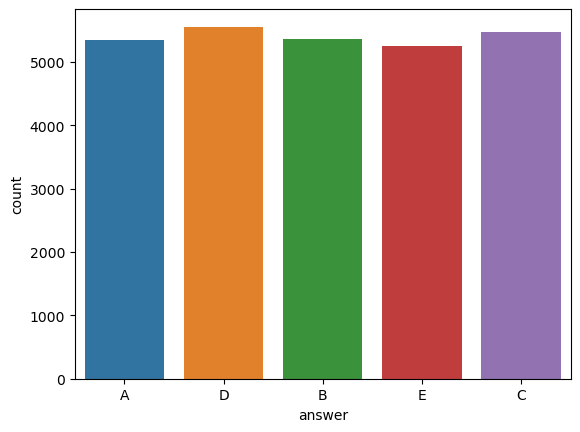

In [9]:
sns.countplot(df_train, x = 'answer') # validating that the classes are uniformly distributed

# Preprocessing

In [10]:
df_train = Dataset.from_pandas(df_train)
df_val = Dataset.from_pandas(df_val)
df_test = Dataset.from_pandas(df_test)

In [11]:
# Adapted from Huggingface Multiple Choice https://huggingface.co/docs/transformers/tasks/multiple_choice
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True) # tokenizer call using 'text_pair' which basically just adds a separator between the two sentences
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [12]:
from transformers import RobertaTokenizer, TFRobertaForMultipleChoice

#distilroberta-base
#tokenizer = RobertaTokenizer.from_pretrained('/kaggle/input/huggingface-roberta-variants/archive/distilroberta-base/distilroberta-base')
#model = TFRobertaForMultipleChoice.from_pretrained('/kaggle/input/huggingface-roberta-variants/archive/distilroberta-base/distilroberta-base')

In [13]:
#xlm-roberta-base
#tokenizer = RobertaTokenizer.from_pretrained('/kaggle/input/huggingface-roberta-variants/archive/roberta-large-mnli/roberta-large-mnli')
#model = TFRobertaForMultipleChoice.from_pretrained('/kaggle/input/huggingface-roberta-variants/archive/tf-xlm-roberta-base/tf-xlm-roberta-base')

In [14]:
tokenized_train_ds = df_train.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_val_ds = df_val.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test_ds = df_test.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])

  0%|          | 0/27000 [00:00<?, ?ex/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/3000 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ex/s]

In [15]:

@dataclass
class DataCollatorForMultipleChoice:
    """
    Data collator that will dynamically pad the inputs for multiple choice received.
    """

    tokenizer:  tokenizer #PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if "label" in features[0].keys() else "labels"
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]["input_ids"])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="tf",
        )

        batch = {k: tf.reshape(v, (batch_size, num_choices, -1)) for k, v in batch.items()}
        batch["labels"] = tf.convert_to_tensor(labels, dtype=tf.int16)
        return batch
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)

# **Training**

In [16]:
batch_size = 8
#steps_per_epoch = 200
num_train_epochs = 10
learning_rate = 1e-4

optimizer = tf.keras.optimizers.Adafactor(
    learning_rate=1e-4,  
    weight_decay=0.01)             
    
model.compile(
    optimizer=optimizer,
    metrics=[
        'accuracy'
    ],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [17]:
EarlyStopping = tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    patience=20,
                    restore_best_weights=True,
                    start_from_epoch=5,
                )
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                              factor=0.8, 
                                              patience=2,
                                              verbose=1, 
                                              min_lr=1e-7)
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [18]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_train_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_val_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    tokenized_test_ds,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)


In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits = 3)
models = {}

for fold, (train_ids, test_ids) in enumerate(kfold.split(tokenized_train_ds)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Subset the dataset.
    train_subset = tokenized_train_ds.select(train_ids)
    test_subset = tokenized_train_ds.select(test_ids)
    
    train_subset = model.prepare_tf_dataset(
    train_subset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
    )

    test_subset = model.prepare_tf_dataset(
    test_subset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
    )
    
    # Create a new instance of the model for each fold.
    #model = TFDistilBertForMultipleChoice.from_pretrained(str(fold) + "DistillBert")

    model.compile(
    optimizer=optimizer,
    metrics=[
        'accuracy'
    ],
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

    model.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs = num_train_epochs,
    #batch_size = batch_size,
    callbacks=[EarlyStopping, reduce_lr, model_checkpoint],
    steps_per_epoch = 200
    )

FOLD 0
--------------------------------
Epoch 1/10
200/200 [==============================] - 196s 768ms/step - loss: 1.6084 - accuracy: 0.2069 - val_loss: 1.6061 - val_accuracy: 0.2997 - lr: 1.0000e-04
Epoch 2/10
200/200 [==============================] - 110s 549ms/step - loss: 1.6049 - accuracy: 0.2181 - val_loss: 1.5951 - val_accuracy: 0.3420 - lr: 1.0000e-04
Epoch 3/10
200/200 [==============================] - 107s 534ms/step - loss: 1.5763 - accuracy: 0.3081 - val_loss: 1.5486 - val_accuracy: 0.3620 - lr: 1.0000e-04
Epoch 4/10
200/200 [==============================] - ETA: 0s - loss: 1.5441 - accuracy: 0.3237

In [ ]:
history = model.fit(
    tf_train_set,
    validation_data=tf_validation_set,
    epochs = num_train_epochs,
    #batch_size = batch_size,
    callbacks=[EarlyStopping, reduce_lr, model_checkpoint],
    steps_per_epoch = 200
)

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.summary()

# Predicting on the test set 

In [ ]:
df_test = pd.DataFrame(df_test) # back to Pandas
test_predictions = model.predict(tf_test_set).logits
predictions_as_ids = np.argsort(-test_predictions, 1)
predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
predictions_as_string = df_test['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]
print(predictions_as_string[:3])

In [ ]:
submission = df_test[['id', 'prediction']]
submission.to_csv('submission.csv', index=False)

pd.read_csv('submission.csv').head(2)

## More to do

- Implement cross-validation
- Augmentation using Google translate from and to EN.

